In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as r
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
from sklearn.base import clone
import ast

C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text
reviews_df.head(3)

Loading datasets...


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0


In [3]:
tags_df = pd.read_csv("comp/tagGamesNoCompoundDF.csv")
tagCountsDF = pd.read_csv("comp/tagCountsDF.csv")
tags_df.head(10)

,app_id,tags
0,10,"['action', 'first-person', 'shooter', 'multipl..."
1,1002,"['2d', 'fighting', 'martial arts', 'intentiona..."
2,100400,"['animation & modeling', 'software']"
3,10090,"['zombies', 'world war ii', 'first-person', 's..."
4,100980,"['animation & modeling', 'utilities', 'design ..."
5,10100,"['adventure', 'point & click', 'classic', 'fan..."
6,10110,"['adventure', 'point & click', 'classic', 'com..."
7,10120,"['action', 'casual', 'space', 'on-rails shoote..."
8,10130,"['action', 'first-person', 'shooter', 'time ma..."
9,10140,"['sports', 'mini golf', 'golf', 'local multipl..."


In [4]:
def filter_rare_tags_by_game(filterDF, tagCountsDF, min_count=1, max_count=7000):
    # Keep tags within the occurrence thresholds
    allowed_tags = set(tagCountsDF.loc[
        (tagCountsDF['occurrences'] >= min_count) & (tagCountsDF['occurrences'] <= max_count),
        'tag'
    ])

    tags_df = filterDF.copy()
    
    # Filter tags per game
    tags_df['tags'] = tags_df['tags'].apply(lambda lst: [tag for tag in lst if tag in allowed_tags])
    
    # Drop games with no tags left
    tags_df = tags_df[tags_df['tags'].str.len() > 0].reset_index(drop=True)
    
    return tags_df


In [5]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------

def aggregate_reviews_per_game(reviews_df: pd.DataFrame, tags_df: pd.DataFrame) -> pd.DataFrame:
    print("Aggregating reviews per game...")

    # Standardize key column name
    reviews_df["app_id"] = reviews_df["app_id"].astype(int, copy=False)
    tags_df["app_id"] = tags_df["app_id"].astype(int, copy=False)

    # Filter reviews that have tags
    reviews_with_tags = (
        reviews_df.loc[reviews_df['app_id'].isin(tags_df['app_id']), ['app_id', 'app_name', 'review_text']]
        .assign(review_text=lambda df: df['review_text'].astype(str))
    )

    # Filter short reviews
    reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)
    reviews_with_tags = reviews_with_tags.loc[
        reviews_with_tags['review_text'].str.count(r'\S+') >= 3
    ]
    print(f"Filtered reviews shape: {reviews_with_tags.shape}")

    # Aggregate per game
    game_reviews = (
        reviews_with_tags
        .groupby("app_id", as_index=False)
        .agg({
            'review_text': lambda texts: " ".join(texts),
            'app_name': 'first'
        })
    )
    print(f"Aggregated reviews shape: {game_reviews.shape}")

    # Merge and parse tags
    game_reviews = game_reviews.merge(tags_df, on="app_id", how='inner')
    game_reviews['tags'] = game_reviews['tags'].apply(ast.literal_eval)

    print(f"Merged game_reviews shape: {game_reviews.shape}")
    print("Sample of final aggregated data:")
    print(game_reviews.head(3))

    return game_reviews

game_reviews = aggregate_reviews_per_game(reviews_df, tags_df)

Aggregating reviews per game...
Filtered reviews shape: (6258189, 3)
Aggregated reviews shape: (9960, 3)
Merged game_reviews shape: (9960, 4)
Sample of final aggregated data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   
2      30  Even though its old, its better than Call of D...   

                app_name                                               tags  
0         Counter-Strike  [action, first-person, shooter, multiplayer, s...  
1  Team Fortress Classic  [action, first-person, shooter, multiplayer, c...  
2          Day of Defeat  [first-person, shooter, world war ii, multipla...  


In [6]:
# lengths = ([len(i) for i in game_reviews['review_text']])
# reviews = []

# reviews_counts = reviews_df.groupby('app_id').size()
# tags_lookup = game_reviews.set_index('app_id')['tags']

# for app_id, count in tqdm.tqdm(reviews_counts.items()):
#     num_tags = len(tags_lookup.get(app_id, []))
#     reviews.append(np.array([count, num_tags]))

# reviews = np.array(reviews)


# # reviews = Counter(reviews)
# print(len(reviews)) # 4521
# print(max(reviews_counts)) # 88973
# print(min(reviews_counts)) # 1

# print(reviews)

In [7]:
# def filter_by_review_threshold(reviews, max_reviews):
#     return [r for r in reviews if r[0] <= max_reviews]

# plt.figure(figsize=(12,10))

# reviews = filter_by_review_threshold(reviews, 500)
# x = [r[0] for r in reviews]  # number of reviews
# y = [r[1] for r in reviews]  # number of tags

# plt.scatter(x, y , color="skyblue", edgecolor="black")

# plt.title("")
# plt.xlabel("# Reviews")
# plt.ylabel("# Tags")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [8]:
# reviews = reviews[reviews[:, 1].argsort()]
# reviews

In [9]:
# min_reviews_for_tag = [[i, None, None, None] for i in range(21)]

# min_reviews = 0

# # assuming your array is named arr
# for tag in range(21):
#     # filter rows where column 1 == tag
#     values = reviews[reviews[:, 1] == tag][:, 0]
#     if values.size > 0:
#         min_reviews_for_tag[tag][1] = values.min()
#         min_reviews_for_tag[tag][2] = values.max()
#         min_reviews_for_tag[tag][3] = round(values.mean(), 3)



# (np.array(min_reviews_for_tag))



In [10]:
# -----------------------------
# 3. Encode text to embeddings
# -----------------------------
original_indices = game_reviews.index.values

def encode_and_save_embeddings(game_reviews, model_name="all-mpnet-base-v2", output_file="base_test.npy"):
    print("Encoding text to embeddings...")
    model = SentenceTransformer(model_name)
    data = model.encode(game_reviews['review_text'].tolist(), show_progress_bar=True)
    np.save(output_file, data)
    return data

reembed = False
if reembed:
    data = encode_and_save_embeddings(game_reviews)
else:
    data = np.load("game_review_embeddings--all-mpnet-base-v2--NoCompound.npy")


In [221]:
game_reviews_filtered = filter_rare_tags_by_game(game_reviews, tagCountsDF, min_count=500, max_count=7000)

game_reviews_filtered = game_reviews_filtered[game_reviews_filtered['tags'].map(bool)]

filtered_embeddings = data[game_reviews_filtered.index]

(game_reviews_filtered.head(2))

,app_id,review_text,app_name,tags
0,10,Ruined my life. This will be more of a ''my ex...,Counter-Strike,"[action, first-person, shooter, multiplayer, s..."
1,20,When I got this for Christmas in 1999 along wi...,Team Fortress Classic,"[action, first-person, shooter, multiplayer, c..."


In [222]:
# Compare text from filtered DataFrame and embeddings
keep_positions = np.where(np.isin(original_indices, game_reviews.index.values))[0]
for i in range(5):
    idx_in_original = keep_positions[i]
    assert game_reviews.iloc[idx_in_original]['review_text'] == game_reviews_filtered.iloc[i]['review_text']


In [223]:
# -----------------------------
# 4. Encode tags to multilabel format
# -----------------------------
print("Encoding tags to multilabel format...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(game_reviews_filtered['tags'])

print(filtered_embeddings.shape)
print(y.shape)  

Encoding tags to multilabel format...
(9837, 768)
(9837, 45)


In [224]:
# -----------------------------
# 5. Train/Test split
# -----------------------------
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, train_ids, test_ids, train_names, test_names = train_test_split(
    filtered_embeddings, y, game_reviews_filtered['app_id'], game_reviews_filtered['app_name'], test_size=0.15, random_state=42
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Splitting data into train and test sets...
(8361, 768) (8361, 45) (1476, 768) (1476, 45)


In [225]:
from sklearn.model_selection import KFold

def kfoldprobs(X_train, y_train, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store test probabilities from each fold
    test_probs_folds = []

    for train_index, val_index in tqdm.tqdm(kf.split(X_train)):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
        clf.fit(X_tr, y_tr)

        # Predict probabilities on your **held-out test set** (not validation fold)
        probs_test = clf.predict_proba(X_test)
        test_probs_folds.append(probs_test)

    # Average probabilities across folds
    probs_test_avg = np.mean(test_probs_folds, axis=0)
    return probs_test_avg


In [226]:
def median_class_weights_linear(X_train, y_train, X_test):
    n_labels = y_train.shape[1]
    label_counts = np.sum(y_train, axis=0)
    median_count = np.median(label_counts)
    
    # Compute per-label median-based weights
    median_class_weights = [{0: 1.0, 1: (median_count / count)*1.8} for count in label_counts]
    
    # Train one LogisticRegression per label
    y_pred = []
    base_clf = LogisticRegression(max_iter=10000, solver='liblinear')
    for i in range(n_labels):
        clf = clone(base_clf)
        clf.set_params(class_weight=median_class_weights[i])
        clf.fit(X_train, y_train[:, i])
        y_pred.append(clf.predict_proba(X_test)[:, 1])  # get probability for positive class
    
    # Stack predictions as (n_samples, n_labels)
    return np.column_stack(y_pred)


In [227]:
# -----------------------------
# 6. Train multilabel classifier
# -----------------------------
def simple_linear(X_train, y_train):
    print("Training multilabel classifier...")
    clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)

In [228]:
# Pick top 5 tags per game
def get_top_n_tags(probs, top_n=20):
    top_n_pred_tags = []
    for prob_row in probs:
        top_indices = prob_row.argsort()[-top_n:][::-1]  # indices of top N probs
        top_tags = [mlb.classes_[i] for i in top_indices]
        top_n_pred_tags.append(top_tags)
    return top_n_pred_tags

def get_treshhold_tags(probs, threshold=0.25):
    dynamic_pred_tags = []

    for prob_row in probs:
        # Get indices where probability > threshold
        tag_indices = np.where(prob_row > threshold)[0]

        if len(tag_indices) == 0:
            # fallback: pick the top 1 tag
            tag_indices = [np.argmax(prob_row)]

        tags = [mlb.classes_[i] for i in tag_indices]
        dynamic_pred_tags.append(tags)
    return dynamic_pred_tags   

In [229]:
probsl = simple_linear(X_train, y_train)
# probsm = median_class_weights_linear(X_train, y_train, X_test)
# kprobs = kfoldprobs(X_train, y_train, X_test, n_splits=10)


Training multilabel classifier...


In [230]:
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

# Convert top-N predicted tag names to a binary matrix
def get_Y_pred(top_n_pred_tags):
    y_pred = np.zeros_like(y_test)

    for i, tags in enumerate(top_n_pred_tags):
        for tag in tags:
            if tag in mlb.classes_:
                idx = list(mlb.classes_).index(tag)
                y_pred[i, idx] = 1
    return y_pred



# y_test: actual multilabel binary matrix
# y_pred: predicted multilabel binary matrix
def ceval(top_n_pred_tags):
    y_pred = get_Y_pred(top_n_pred_tags)
    # Hamming Loss
    hl = hamming_loss(y_test, y_pred)
    print("Hamming Loss:", hl)

    # Micro-averaged precision, recall, F1 (across all games)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    print(f"Micro Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # Macro-averaged F1 (average per tag)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 (per tag): {f1_macro:.3f}")

In [231]:
for i in [0.1, 0.15, 0.2, 0.25, .3]:
    print("\n ----------- \nResults for threshold =", i)
    top_n_pred_tags = get_treshhold_tags(probsl, threshold=i)
    # print("Results for simple linear model:")
    # ceval(top_n_pred_tags)
    # top_n_pred_tags = get_top_n_tags(probsl, top_n=8)
    # print("\n ----------- \nResults for simple linear model (top 8):")
    # top_n_pred_tags = get_treshhold_tags(probsm, threshold=i)
    print("\n ----------- \nResults for median class weights linear model:")
    # top_n_pred_tags = get_treshhold_tags( kprobs, threshold=i)
    # print("\n ----------- \nResults for k-fold model:")
    ceval(top_n_pred_tags)


 ----------- 
Results for threshold = 0.1

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.4685185185185185
Micro Precision: 0.219, Recall: 0.775, F1: 0.342
Macro F1 (per tag): 0.248

 ----------- 
Results for threshold = 0.15

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.2886178861788618
Micro Precision: 0.294, Recall: 0.596, F1: 0.394
Macro F1 (per tag): 0.201

 ----------- 
Results for threshold = 0.2

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.2144384221619994
Micro Precision: 0.362, Recall: 0.479, F1: 0.412
Macro F1 (per tag): 0.157

 ----------- 
Results for threshold = 0.25

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.1786058416139717
Micro Precision: 0.426, Recall: 0.395, F1: 0.410
Macro F1 (per tag): 0.124

 ----------- 
Results for threshold = 0.3

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.16485998193315266
Micro P

In [232]:
# -----------------------------
# 7. Predict and align with game info
# -----------------------------

actual_tags = mlb.inverse_transform(y_test) 


# Example: print top 5 predicted tags for first 5 games
gam = r.randint(0, len(test_names)-1)
for i in range(gam, gam+5):
    print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
    print("  Predicted tags:", top_n_pred_tags[i])  # only show tags not in actual
    print("  Actual tags   :", list(actual_tags[i]))
    print(f"{len(set(top_n_pred_tags[i]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
    print()
# -----------------------------
# gam = r.randint(0, len(test_names)-1)
# for i in range(gam, gam+5):
#     print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
#     print("  Predicted tags:", top_n_pred_tags[i][:len(actual_tags[i])])
#     print("  Actual tags   :", list(actual_tags[i]))
#     print(f"{len(set(top_n_pred_tags[i][:len(actual_tags[i])]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
#     print()


Word Wonders: The Tower of Babel (app_id=362790)
  Predicted tags: ['action', 'adventure', 'casual', 'indie', 'singleplayer']
  Actual tags   : ['casual']
1/1 tags correct

Namariel Legends: Iron Lord Premium Edition (app_id=302730)
  Predicted tags: ['action', 'adventure', 'casual', 'indie', 'singleplayer']
  Actual tags   : ['adventure', 'casual', 'indie', 'point & click']
3/4 tags correct

Higurashi When They Cry Hou - Ch.2 Watanagashi (app_id=410890)
  Predicted tags: ['action', 'adventure', 'casual', 'indie', 'simulation', 'singleplayer']
  Actual tags   : ['2d', 'adventure', 'anime', 'atmospheric', 'classic', 'cute', 'gore', 'great soundtrack', 'horror', 'indie', 'singleplayer', 'story rich']
3/12 tags correct

Fowl Space (app_id=109500)
  Predicted tags: ['action', 'adventure', 'indie', 'rpg', 'singleplayer', 'strategy']
  Actual tags   : ['action', 'indie']
2/2 tags correct

Indie Graphics Bundle (app_id=281900)
  Predicted tags: ['action', 'adventure', 'casual', 'indie', 'sing

In [233]:
from collections import defaultdict

tag_correct = defaultdict(int)      # how many times a tag was correctly predicted
tag_pred_total = defaultdict(int)   # how many times a tag was predicted
tag_actual_total = defaultdict(int) # how many times a tag actually appeared

# Loop through full test set
for pred_tags, act_tags in zip(top_n_pred_tags, actual_tags):
    pred_set = set(pred_tags)
    act_set = set(act_tags)

    # Count actual appearances
    for t in act_set:
        tag_actual_total[t] += 1

    # Count predictions
    for t in pred_set:
        tag_pred_total[t] += 1

    # Count correct predictions (intersection)
    for t in pred_set & act_set:
        tag_correct[t] += 1


In [234]:

tag_stats = pd.DataFrame({
    'Correct': pd.Series(tag_correct),
    'Predicted': pd.Series(tag_pred_total),
    'Actual': pd.Series(tag_actual_total),
})

tag_stats['Precision'] = tag_stats['Correct'] / tag_stats['Predicted']  # How reliable predictions were
tag_stats['Recall'] = tag_stats['Correct'] / tag_stats['Actual']        # How often tag was caught
tag_stats['F1'] = 2 * tag_stats['Precision'] * tag_stats['Recall'] / (tag_stats['Precision'] + tag_stats['Recall'])
tag_stats['F1'] = tag_stats['F1'].fillna(0)  # handle divide by zero if needed

tag_stats['PR_dif'] = abs(tag_stats['Precision'] - tag_stats['Recall'])
tag_stats['PA_ratio'] = abs(tag_stats['Predicted'] / tag_stats['Actual'])

tag_stats = tag_stats.fillna(0).sort_values('F1', ascending=False)


In [235]:
# tag_stats.sort_values('Correct', ascending=False).head(10)
# tag_stats[tag_stats['Predicted'] > 5].sort_values('Precision', ascending=False).head(10)
# tag_stats[tag_stats['Actual'] > 5].sort_values('Recall').head(10)
# tag_stats.sort_values('F1', ascending=False).head(25)
# tag_stats.sort_values('PR_dif', ascending=False).head(10)
tag_stats.sort_values('PA_ratio', ascending=True).head(10)


,Correct,Predicted,Actual,Precision,Recall,F1,PR_dif,PA_ratio
space,0.0,0.0,93,0.0,0.0,0.0,0.0,0.0
female protagonist,0.0,0.0,169,0.0,0.0,0.0,0.0,0.0
arcade,0.0,0.0,132,0.0,0.0,0.0,0.0,0.0
co-op,0.0,0.0,171,0.0,0.0,0.0,0.0,0.0
comedy,0.0,0.0,108,0.0,0.0,0.0,0.0,0.0
sandbox,0.0,0.0,102,0.0,0.0,0.0,0.0,0.0
controller,0.0,0.0,79,0.0,0.0,0.0,0.0,0.0
retro,0.0,0.0,140,0.0,0.0,0.0,0.0,0.0
cute,0.0,0.0,113,0.0,0.0,0.0,0.0,0.0
point & click,0.0,0.0,132,0.0,0.0,0.0,0.0,0.0


In [236]:
def find_unpredicted_tags(top_n_pred_tags, actual_tags):
    return set([item for sublist in actual_tags for item in sublist]) - set([item for sublist in top_n_pred_tags for item in sublist])
unpredicted_tags = find_unpredicted_tags(top_n_pred_tags, actual_tags)
print(f"{len(unpredicted_tags)} Unpredicted tags:", unpredicted_tags)

25 Unpredicted tags: {'gore', 'pixel graphics', 'sandbox', 'exploration', 'comedy', 'space', 'controller', 'vr', 'point & click', 'cute', 'fantasy', 'female protagonist', 'retro', 'free to play', 'early access', 'turn-based', 'anime', 'co-op', 'third person', 'open world', 'arcade', 'platformer', 'family friendly', 'horror', 'survival'}


In [237]:

def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])
    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)
    print(len(flat), len(unique))

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X= np.unique(np.concatenate(top_n_pred_tags)).size
top_pred = find_top_x(top_n_pred_tags, x=X, print_output=False)
top_act = find_top_x(actual_tags, x=X, print_output=False)


print(len(top_pred[0]), len(top_act[0]), len(top_pred[1]), len(top_act[1]))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

df_compare.head(15)

7758 20
10438 45
20 20 20 20


,pred_Tag,pred_count,act_Tag,act_count
0,action,1476,indie,938
1,indie,1472,action,748
2,adventure,1450,adventure,686
3,singleplayer,1440,singleplayer,670
4,casual,1107,casual,501
5,strategy,334,strategy,374
6,multiplayer,121,multiplayer,339
7,simulation,110,2d,321
8,rpg,51,simulation,315
9,atmospheric,45,rpg,307


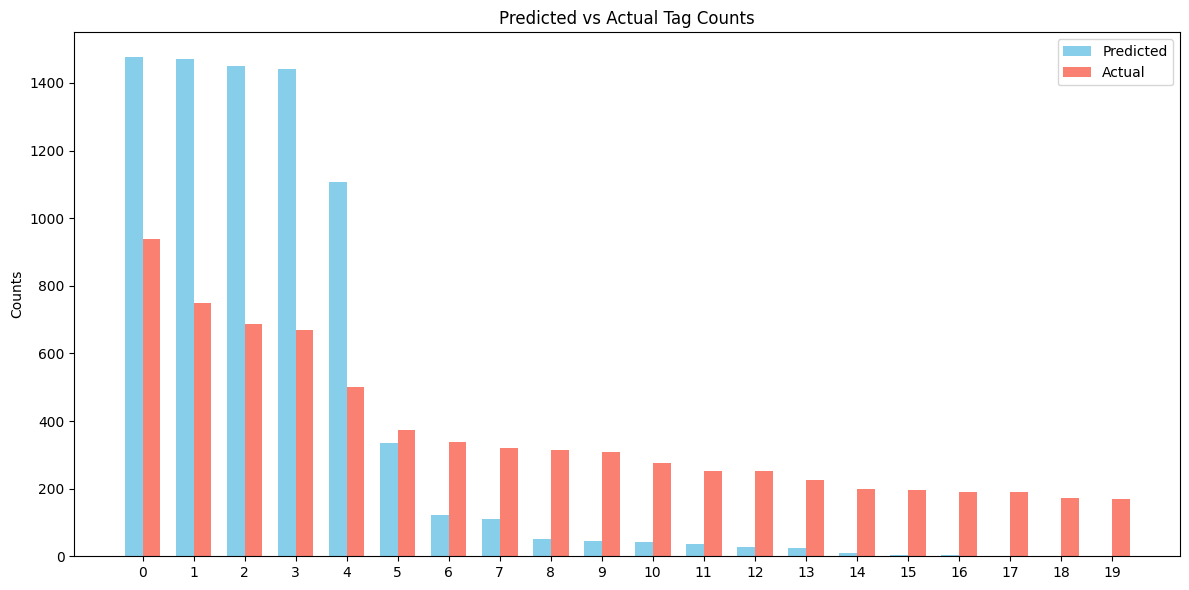

In [238]:

def countHistogram(df_compare:pd.DataFrame, top=35, labels=True):
    top_n = top
    df_top = df_compare.head(top_n)

    x = np.arange(top_n)  # positions for each tag
    width = 0.35          # width of bars

    fig, ax = plt.subplots(figsize=(12,6))

    # Bars
    ax.bar(x - width/2, df_top['pred_count'], width, label='Predicted', color='skyblue')
    ax.bar(x + width/2, df_top['act_count'], width, label='Actual', color='salmon')

    # Labels
    ax.set_ylabel('Counts')
    ax.set_title('Predicted vs Actual Tag Counts')
    ax.set_xticks(x)
    if labels:
        ax.set_xticklabels(df_top['pred_Tag'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

countHistogram(df_compare, top=min(np.unique(np.concatenate(top_n_pred_tags)).size, 30),labels=False)

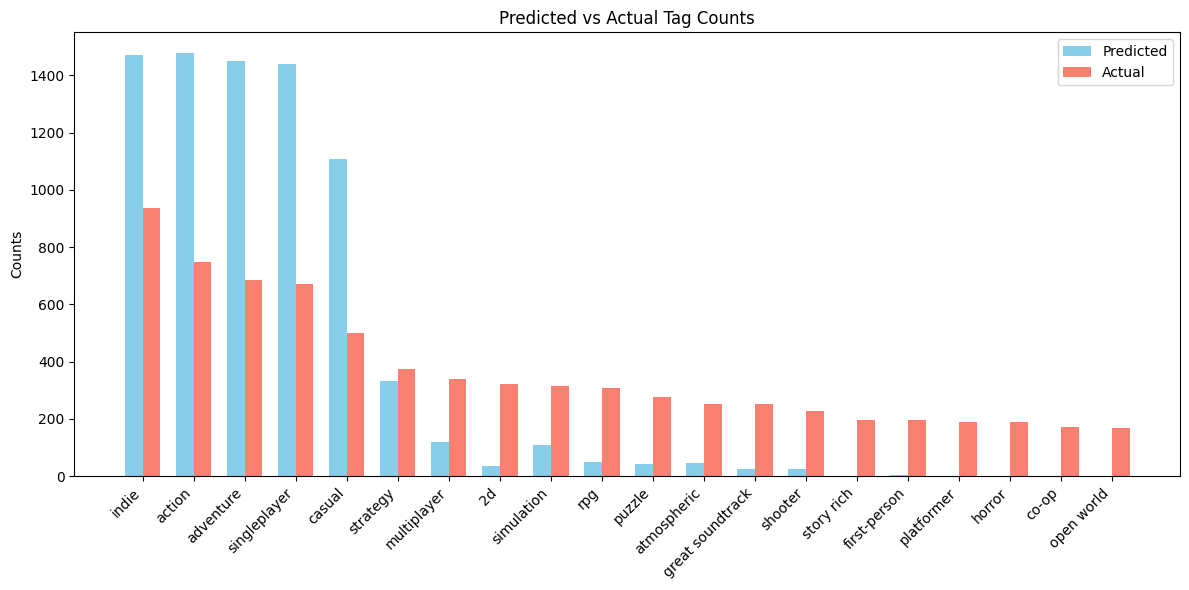

In [239]:
# Make a mapping from predicted tags to their counts
pred_map = dict(zip(top_pred[0], top_pred[1]))

# Reorder pred counts to follow actual tag ordering
new_act_tags = top_act[0]                  # actual tags are the reference
new_pred_counts = [pred_map.get(tag, 0) for tag in new_act_tags]  # fallback 0 if missing

# Build dataframe using aligned lists
df_compare = pd.DataFrame({
    'pred_Tag': new_act_tags,        # aligned with actual tags
    'pred_count': new_pred_counts,   # predicted counts reordered
    'act_Tag': new_act_tags,
    'act_count': top_act[1]
})

countHistogram(df_compare, top=min(np.unique(np.concatenate(top_n_pred_tags)).size, 35))


In [240]:

def plot_tag_count_distribution_hist(pred_counts, actual_counts, bins=20, title="Tag Count Distribution"):
    """
    Plots the distribution of tag counts using a histogram with bins and a line overlay.
    
    Args:
        pred_counts (array-like): counts of each predicted tag
        actual_counts (array-like): counts of each actual tag
        bins (int or sequence): number of bins or bin edges
        title (str): plot title
    """
    plt.figure(figsize=(12,6))
    
    # Histogram for actual counts
    counts_actual, bin_edges = np.histogram(actual_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, counts_actual, width=(bin_edges[1]-bin_edges[0])*0.4, alpha=0.6,
            label='Actual', color='salmon', edgecolor='black')
    plt.plot(bin_centers, counts_actual, color='red', marker='o', linestyle='-', label='Actual (line)')
    
    # Histogram for predicted counts
    counts_pred, _ = np.histogram(pred_counts, bins=bin_edges)
    plt.bar(bin_centers + (bin_edges[1]-bin_edges[0])*0.4, counts_pred, width=(bin_edges[1]-bin_edges[0])*0.4,
            alpha=0.6, label='Predicted', color='skyblue', edgecolor='black')
    plt.plot(bin_centers, counts_pred, color='blue', marker='o', linestyle='-', label='Predicted (line)')
    
    plt.xlabel("Number of occurrences of a tag")
    plt.ylabel("Number of tags in that bin")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [241]:
def tag_distribution_report(tag_tuple, name="Tag Distribution"):
    """
    Generate a report on the distribution of tag counts.
    tag_tuple: tuple (tags_list, counts_list)
    name: label of the dataset (e.g. 'Predicted' or 'Actual')
    """
    tags, counts = tag_tuple
    counts = np.array(counts)

    report = {
        "Dataset Name": name,
        "Total Unique Tags": len(tags),
        "Total Tag Assignments": counts.sum(),
        "Mean Tag Frequency": counts.mean(),
        "Median Tag Frequency": np.median(counts),
        "Min Tag Frequency": counts.min(),
        "Max Tag Frequency": counts.max(),
        "Std Dev": counts.std(),
        "10th Percentile": np.percentile(counts, 10),
        "25th Percentile": np.percentile(counts, 25),
        "50th Percentile": np.percentile(counts, 50),
        "75th Percentile": np.percentile(counts, 75),
        "90th Percentile": np.percentile(counts, 90),
        "Tags Occurring Once": np.sum(counts == 1),
        "Tags Occurring <= 5": np.sum(counts <= 5),
        "Top 10 Tags Coverage (%)": round(100 * counts[:10].sum() / counts.sum(), 2)
    }

    return pd.DataFrame.from_dict(report, orient='index', columns=[name])


7758 20
10438 45
                          Predicted Tags
Dataset Name              Predicted Tags
Total Unique Tags                     20
Total Tag Assignments               7758
Mean Tag Frequency                 387.9
Median Tag Frequency                43.5
Min Tag Frequency                      1
Max Tag Frequency                   1476
Std Dev                       586.731531
10th Percentile                      1.9
25th Percentile                     8.75
50th Percentile                     43.5
75th Percentile                   527.25
90th Percentile                   1452.2
Tags Occurring Once                    2
Tags Occurring <= 5                    5
Top 10 Tags Coverage (%)           98.04 
                           Actual Tags
Dataset Name              Actual Tags
Total Unique Tags                  45
Total Tag Assignments           10438
Mean Tag Frequency         231.955556
Median Tag Frequency            166.0
Min Tag Frequency                  79
Max Tag Frequency 

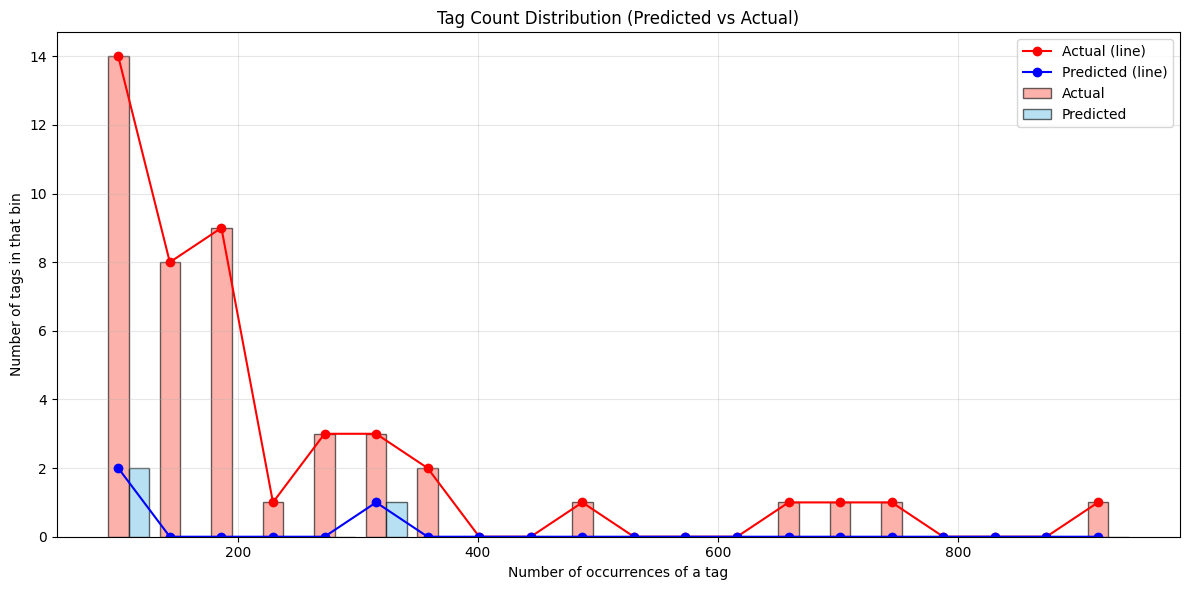

In [242]:
top_pred = find_top_x(top_n_pred_tags, x=len(top_n_pred_tags), print_output=False)
top_act = find_top_x(actual_tags, x=len(actual_tags), print_output=False)

print(tag_distribution_report(top_pred, name="Predicted Tags"), "\n",
tag_distribution_report(top_act, name="Actual Tags"))
plot_tag_count_distribution_hist(top_pred[1], top_act[1], title="Tag Count Distribution (Predicted vs Actual)")